In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import time
movies = pd.read_csv('movie_industry_clean.csv')

In [2]:
movies.head()

,Unnamed: 0,index,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime
0,0,0,The Shining,R,Drama,1980,"June 13, 1980 (United States)",8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,19000000.0,46998772.0,Warner Bros.,146.0
1,1,1,The Blue Lagoon,R,Adventure,1980,"July 2, 1980 (United States)",5.8,65000.0,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4500000.0,58853106.0,Columbia Pictures,104.0
2,2,2,Star Wars: Episode V - The Empire Strikes Back,PG,Action,1980,"June 20, 1980 (United States)",8.7,1200000.0,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,18000000.0,538375067.0,Lucasfilm,124.0
3,3,3,Airplane!,PG,Comedy,1980,"July 2, 1980 (United States)",7.7,221000.0,Jim Abrahams,Jim Abrahams,Robert Hays,United States,3500000.0,83453539.0,Paramount Pictures,88.0
4,4,4,Caddyshack,R,Comedy,1980,"July 25, 1980 (United States)",7.3,108000.0,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,6000000.0,39846344.0,Orion Pictures,98.0


In [7]:
# split into training & test
np.random.seed(2)
train = movies.sample(round(movies.shape[0]*0.8)) # 80%
test = movies.drop(train.index)
train = train.drop('Unnamed: 0', axis=1)
train = train.drop('index', axis=1)
test = test.drop('Unnamed: 0', axis=1)
test = test.drop('index', axis=1)

In [8]:
# doing VIF to see if there is multicollinearity
X = train[['year','score','votes','budget','runtime']]
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
X = add_constant(X)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

for i in range(len(X.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(X.values, i)

print(vif_data)

   feature           VIF
0    const  40965.310821
1     year      1.130068
2    score      1.512960
3    votes      1.685885
4   budget      1.499190
5  runtime      1.347823


In [9]:
# There is very little collinearity.

<AxesSubplot:>

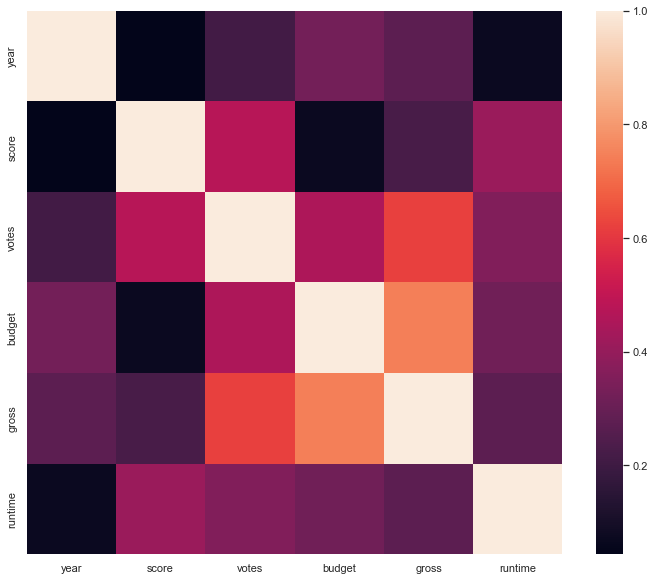

In [11]:
sns.set(rc={'figure.figsize':(12,10)})
sns.heatmap(train.corr())

In [4]:
train.replace(' ', '_', regex=True, inplace = True)

In [5]:
#Creating a set of predictors from which we need to find the best subset of predictors
X = train[['rating','genre','year','score','votes','country','budget','runtime']]

In [6]:
#Function to develop a model based on all predictors in predictor_subset
def processSubset(predictor_subset):
    # Fit model on feature_set and calculate R-squared
    model = sm.ols('gross~' + '+'.join(predictor_subset),data = train).fit()
    Rsquared = model.rsquared
    return {"model":model, "Rsquared":Rsquared}

In [7]:
#Function to select the best model amongst all models with 'k' predictors
def getBest_model(k):
    tic = time.time()
    results = []
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset((list(combo))))

    # Wrap everything up in a dataframe
    models = pd.DataFrame(results)

    # Choose the model with the highest RSS
    best_model = models.loc[models['Rsquared'].argmax()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    return best_model

In [8]:
def best_sub_plots():
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

    # Set up a 2x2 grid so we can look at 4 plots at once
    plt.subplot(2, 2, 1)

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector
    plt.plot(models_best["Rsquared"])
    plt.xlabel('# Predictors')
    plt.ylabel('Rsquared')

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector

    rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)

    plt.subplot(2, 2, 2)
    plt.plot(rsquared_adj)
    plt.plot(1+rsquared_adj.argmax(), rsquared_adj.max(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('adjusted rsquared')

    # We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
    aic = models_best.apply(lambda row: row[1].aic, axis=1)

    plt.subplot(2, 2, 3)
    plt.plot(aic)
    plt.plot(1+aic.argmin(), aic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('AIC')

    bic = models_best.apply(lambda row: row[1].bic, axis=1)

    plt.subplot(2, 2, 4)
    plt.plot(bic)
    plt.plot(1+bic.argmin(), bic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('BIC')

In [9]:
#Since 'X' will change when we include interactions, we need a backup containing all individual predictors
X_backup = train[['rating','genre','year', 'score','votes','country','budget','company','runtime']]

In [10]:
#Function to find the best predictor out of p-k predictors and add it to the model containing the k predictors
def forward(predictors):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
    
    tic = time.time()
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['Rsquared'].argmax()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [11]:
def forward_selection():
    models_best = pd.DataFrame(columns=["Rsquared", "model"])

    tic = time.time()
    predictors = []

    for i in range(1,len(X.columns)+1):    
        models_best.loc[i] = forward(predictors)
        predictors = list(models_best.loc[i]["model"].params.index[1:])

    toc = time.time()
    print("Total elapsed time:", (toc-tic), "seconds.")
    return models_best

In [12]:
train.rating.unique()

array(['PG-13', 'R', 'PG', 'Not_Rated', 'G', 'Unrated', 'X', 'NC-17',
       'Approved', 'TV-MA'], dtype=object)

In [13]:
models_best = forward_selection()

Processed  8 models on 1 predictors in 0.19240784645080566 seconds.
Processed  7 models on 2 predictors in 0.11457514762878418 seconds.
Processed  6 models on 3 predictors in 0.13295197486877441 seconds.


PatsyError: Error evaluating factor: NameError: name 'T' is not defined
    gross~genre[T.Adventure]+genre[T.Animation]+genre[T.Biography]+genre[T.Comedy]+genre[T.Crime]+genre[T.Drama]+genre[T.Family]+genre[T.Fantasy]+genre[T.Horror]+genre[T.Mystery]+genre[T.Romance]+genre[T.Sci-Fi]+genre[T.Thriller]+genre[T.Western]+budget+votes+rating
          ^^^^^^^^^^^^^^^^^^